# Experiment: 
Data Gen: Latin Hypercube Sampling

### Imports

In [46]:
# !pip install --upgrade pyDOE

In [47]:
# Selctiong Version, Google Colab only
# %tensorflow_version 1.x
try:
  %tensorflow_version 1.x # Colab only
except Exception:
    pass
 
# Imports
import numpy as np
import time
import tensorflow as tf
from scipy import signal
import sys
# import scipy.io
# from numpy import fft
# from plotting import newfig, savefig
import matplotlib.pyplot as plt
# from pyDOE import lhs
# import seaborn as sns
# sns.set()
%matplotlib inline
import datetime
# plt.style.use('style/elegant.mplstyle')
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # Colab only`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
1.15.2


In [48]:
from google.colab import drive
drive.mount('/content/gdrive')
# filePath = '/content/gdrive/My Drive/Colab Notebooks/stepFunction'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [49]:
np.random.seed(1234)
tf.set_random_seed(1234)
np.set_printoptions(threshold=sys.maxsize)

In [50]:
###================== Function for approximation =======================###
## Function for approximation
def step_function(x):
    # noise = np.random.normal(0, 0.1, 1)
    f = np.zeros(len(x))
    f = np.reshape(f,(-1, 1))
    for i in range(len(x)):
        if x[i] < 0:
            # f[i] = 0.2 * np.sin(6*x[i]) #+ np.random.normal(0, 0.001, 1)
            f[i] = 0
        else:
            # f[i] = 1 + 0.1 * x[i] * np.cos(18*x[i]) #+ np.random.normal(0, 0.001, 1)
            f[i] = 1
    return f

## Function for approximation
def non_linear_step_function(x):
    # noise = np.random.normal(0, 0.1, 1)
    f = np.zeros(len(x))
    f = np.reshape(f,(-1, 1))
    for i in range(len(x)):
        if x[i] < 0:
            f[i] = 0.2 * np.sin(6*x[i]) #+ np.random.normal(0, 0.001, 1)
            # f[i] = 0
        else:
            f[i] = 1 + 0.1 * x[i] * np.cos(18*x[i]) #+ np.random.normal(0, 0.001, 1)
            # f[i] = 1
    return f


## Function for approximation
def smooth_function(x):
    # noise = np.random.normal(0, 0.1, 1)
    f = np.zeros(len(x))
    f = np.reshape(f,(-1, 1))
    for i in range(len(x)):
        f[i] = (x[i]**3 - x[i])*(np.sin(7*x[i]) / 7.0) + np.sin(12*x[i])
    return f


In [51]:
# Chebyshev nodes
def chebNodes(a, b, n):
  x = []
  for k in range(1, N + 1):
    node = 0.5*(a + b) + 0.5*(b - a)*np.cos((2*(n - k) - 1)*np.pi/(2*N))
    x.append(node)
  return np.asanyarray(x, dtype= np.float32)

# def fft(numPoints, yt):
#   """numPoints -> N, yt -> signal """
#   n = len(yt) # length of the signal
#   k = np.arange(n) 
#   T = n/numPoints
#   # print(T)
#   frq = k/T # two sides frequency range
#   # print(frq)
#   frq = frq[range(n//2)] # one side frequency range
#   # print(frq)
#   ## fft now
#   FFTYT = np.fft.fft(yt)//n ## fft computing and normalization
#   FFTYT = FFTYT[range(n//2)] # one side frequency range
#   fftyt = abs(FFTYT)
#   return frq, fftyt 

def fft(x, yt):
  """x -> data points, yt -> signal """
  n = len(x)
  freq = np.fft.fftfreq(n, d = x[1]-x[0])
  freq = freq[range(n//2)] # one side frequency range
  FFTYT = np.fft.fft(yt, norm="ortho") # np.fft.fft(yt)//n ## fft computing and normalization
  FFTYT = FFTYT[range(n//2)] # one side frequency range
  fftyt = np.abs(FFTYT)
  return freq, fftyt 


def plot_wave_and_spectrum(x, yox):
  """x -> data points, yt -> signal """
  k, yok = fft(x, yox) # k -> frequency index
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,8))
  ax0.set_title("Function")
  ax0.plot(x, yox)
  ax0.set_xlabel("x")
  ax0.set_ylabel("f(x)")
  ax1.set_title("FT of Function")
  # ax1.scatter(k, yok)
  ax1.plot(k, yok)
  ax1.set_xlabel("k")
  ax1.set_ylabel("f(k)")
  plt.show()

In [52]:
#### Network description & utilites Utilities###
## Utilities
def fetch_minibatch(X, Y, N_batch):
  """N_batch --> batch size """
  X = np.asarray(X, dtype=np.float32).reshape(-1, 1)
  Y = np.asarray(Y, dtype=np.float32).reshape(-1, 1)
  N = X.shape[0]
  idx = np.random.choice(N, N_batch, replace=False)
  X_batch = X[idx, :]
  Y_batch = Y[idx, :]
  return X_batch, Y_batch

## Neural Network ##
# Xavier initializer
def xavier_init(size):
  """ Weight initilizer: Xavier method"""
  in_dim = size[0]
  out_dim = size[1]
  xavier_stddev = np.sqrt(2/(in_dim + out_dim))
  return tf.Variable(tf.random.truncated_normal(shape=[in_dim, out_dim], mean = 0.0, stddev=xavier_stddev), dtype=tf.float32)

# return tf.Variable(tf.random_normal(shape=size, mean = 0., stddev = 0.1), dtype=tf.float32)

# Initialization
def initialize_NN(layer):
  """Initilize the network """
  weights = []
  biases = []
  slope_control = [] # Slope control parameter
  num_layers = len(layers)
  for l in range(0, num_layers-1):
    W = xavier_init(size=[layers[l], layers[l+1]])
    b = tf.Variable(tf.zeros(shape=[1, layers[l+1]], dtype=tf.float32), dtype=tf.float32)
    a = tf.Variable(tf.constant(0.1, shape=[1, layers[l+1]]))
    weights.append(W)
    biases.append(b)
    slope_control.append(a)
  return weights, biases, slope_control


# Actual Neural Net (Paper)
def neural_net(input, weights, biases, slope_control, dropout):
  num_layers = len(weights)
  H = input
  for l in range(0, num_layers - 1):
    W = weights[l]
    b = biases[l]
    a = slope_control[l]
    H = tf.tanh(10*a*tf.add(tf.matmul(H, W), b))
    # H = tf.nn.dropout(H, dropout) #keep_prob = 0.1 # DROP-OUT here
  W = weights[-1]
  b = biases[-1]
  a = slope_control[-1]
  Y = tf.add(tf.matmul(H, W), b)
  return Y

## Modified Neural Net
def neural_net_modified(input, weights, biases, slope_control, dropout):
    H = input   # 2.0 * (X - lb) / (ub - lb) - 1.0
    W = weights
    b = biases
    a = slope_control
    num_layers = len(W)
    for l in range(0, num_layers-1):
        if l % 2 == 0:
            H = tf.sin(10*a[l]*tf.add(tf.matmul(H, W[l]), b[l]))
            # H = tf.nn.dropout(H, dropout) #keep_prob = 0.9
        else:
            H = tf.tanh(10*a[l]*tf.add(tf.matmul(H, W[l]), b[l]))
            # H = tf.nn.dropout(H, dropout) #keep_prob = 0.9
    Y = tf.add(tf.matmul(H, W[-1]), b[-1])
    return Y

##======= Slope recovery term =======###
def S_tanh(a):
  y = 0
  for i in range(0, len(a)):
      y += tf.tanh(tf.reduce_mean(a[i]))
  slope_term = 1/(tf.reduce_mean(y)) 
  return slope_term

def S_exp(a):
  y = 0
  for i in range(0, len(a)):
      y += tf.exp(tf.reduce_mean(a[i]))
  slope_term = 1/(tf.reduce_mean(y)) 
  return slope_term

# Choosing x from different distribution

Number of Training Data: 4096


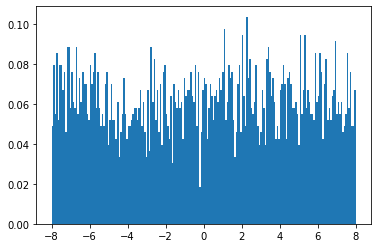

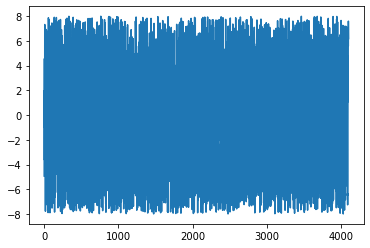

In [53]:
##====== x-Data Preparation ==========###
N = 2**12 # number of trainig point
# print(f"Number of Data: {N}")
print(f"Number of Training Data: {N}")
# x = np.linspace(-3, 3, N + 1)
lb = -8 # lower bound
ub = 8 # uppder bound
rng = np.random.default_rng()
x = ((ub - lb) * np.random.uniform(0, 1, N) + lb).reshape(-1, 1)
# rng = np.random.default_rng()
values = plt.hist(x, bins=200, density=True)
plt.show()
fig = plt.figure()
plt.plot(x)

# Non Linear Step Function


### Data Preparation

train_x shape: (4096, 1)
train_y shape: (4096, 1)
test_x shape: (4096, 1)
test_y shape: (4096, 1)


False

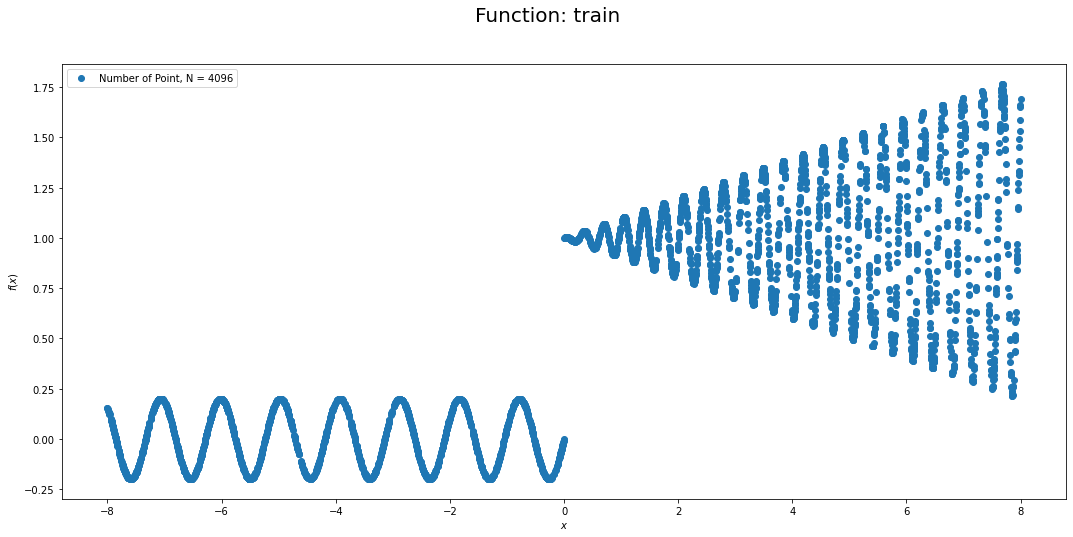

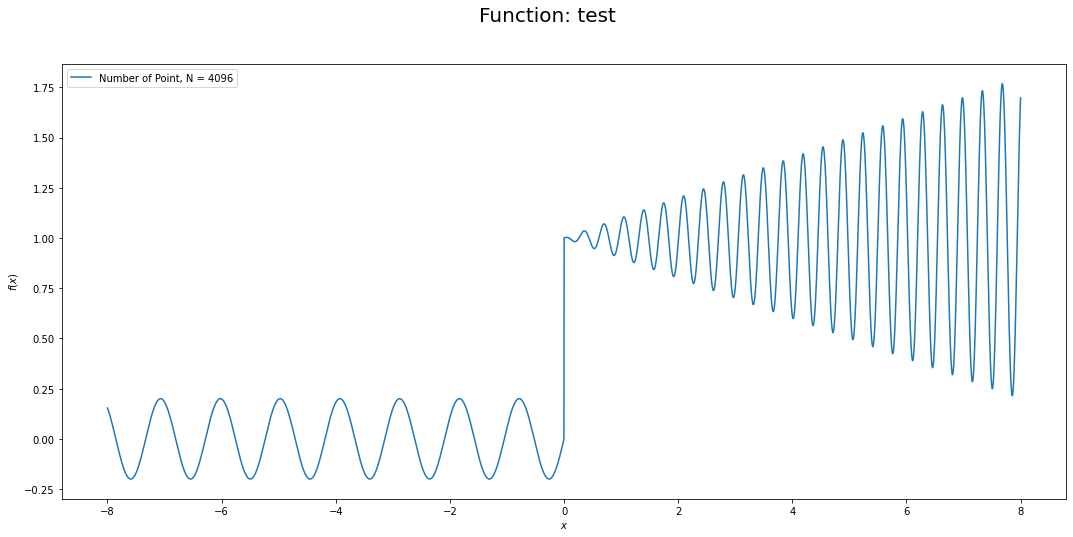

In [54]:
# ##====== Data Preparation ==========###
# N = 2**12 # number of trainig point
# print(f"Number of Data: {N}")
# print(f"Number of Training Data: {N}")
# # x = np.linspace(-3, 3, N + 1)

# lb = -8 # lower bound
# ub = 8 # uppder bound

# # ####### Synthetic Data Generation: Training ######### #
# # x1 = chebNodes(lb, 0, N)
# # x2 = chebNodes(0, ub, N)

# x = np.random.triangular(lb, 0, ub, N).reshape(-1, 1)

y = non_linear_step_function(x)

train_x = x
train_y = y

train_x = np.asarray(train_x, dtype=np.float32).reshape(-1, 1)
train_y = np.asarray(train_y, dtype=np.float32).reshape(-1, 1)

print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}")

fig = plt.figure(figsize=[18, 8])
plt.scatter(train_x, train_y, label = 'Number of Point, N = %d' %N)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='best')
fig.suptitle('Function: train', fontsize=20)

######## Synthetic Data Generation: Testing ##########
test_x = np.linspace(lb, ub, N, dtype=np.float32)
test_y = non_linear_step_function(test_x)

# plot_wave_and_spectrum(x, y)

test_x = np.asarray(test_x, dtype=np.float32).reshape(-1, 1)
test_y = np.asarray(test_y, dtype=np.float32).reshape(-1, 1)

print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_y.shape}")
fig = plt.figure(figsize=[18, 8])
plt.plot(test_x, test_y, label = 'Number of Point, N = %d' %N)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='best')
fig.suptitle('Function: test', fontsize=20)
# # fig.savefig('/content/drive/My Drive/Colab Notebooks/Current/sawtooth_wave.png')
np.array_equal(train_x, test_x)

### Network

Summary: 
Max Iteration: 32768
Number of training Data Points: 4096
Batch Size: 1024
Learning Rate: 0.0003
Layers:  1 50 50 50 50 1
For Learning rate =  0.0003
Steps : 8192, loss: 1.039e-01
Steps : 16384, loss: 6.113e-02
Steps : 24576, loss: 2.658e-02
Steps : 32768, loss: 3.286e-03
Training time: 00:02:06.53
================== Modified =====================
Summary: 
Max Iteration: 32768
Number of training Data Points: 4096
Batch Size: 1024
Learning Rate: 0.0003
Layers:  1 50 50 50 50 1
For Learning rate =  0.0003
Steps : 8192, loss: 5.995e-02
Steps : 16384, loss: 9.928e-03
Steps : 24576, loss: 1.800e-03
Steps : 32768, loss: 8.623e-04
Training time: 00:02:08.80


Text(0.5, 0.98, 'MSE vs Iteration Plot')

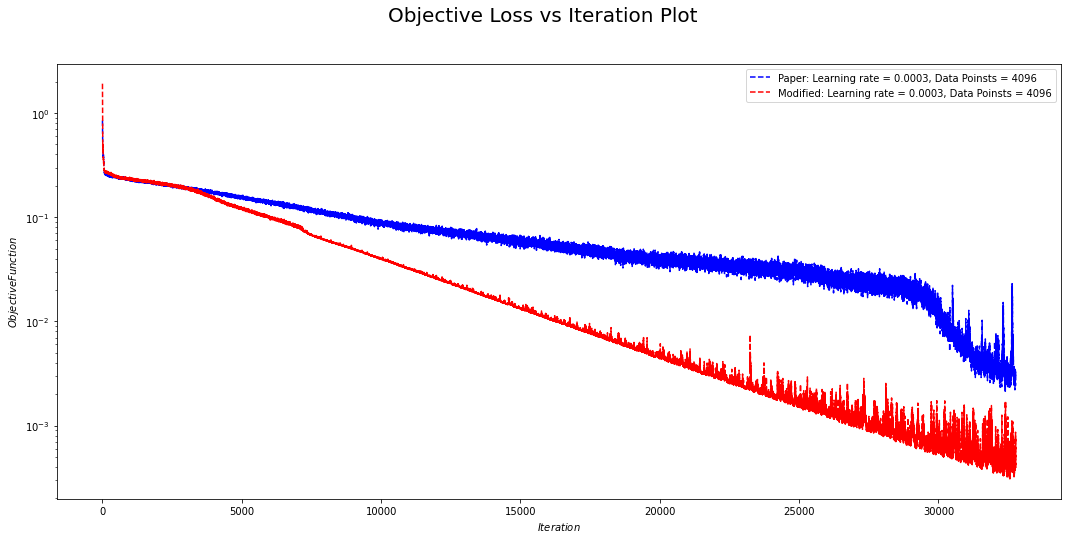

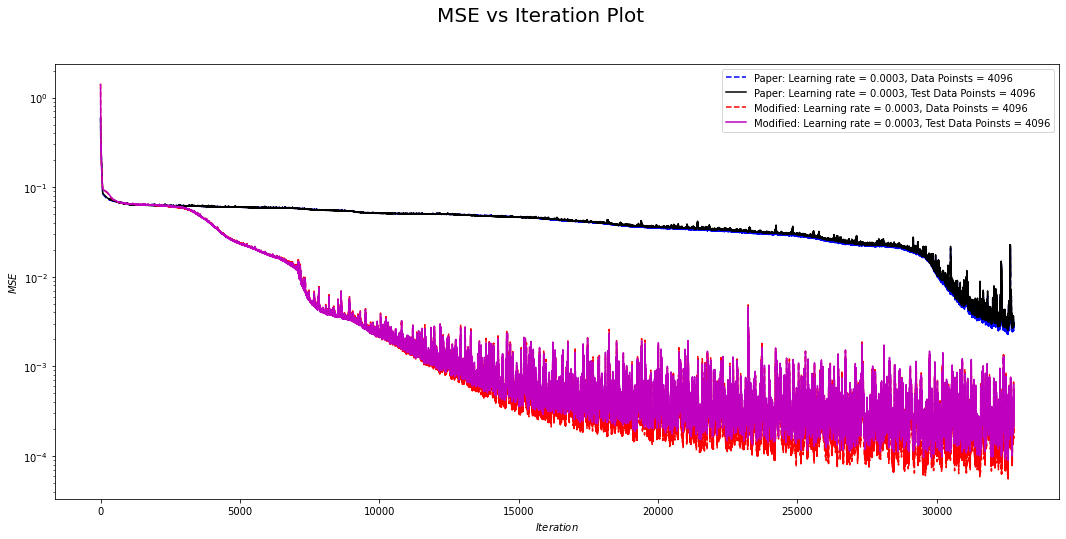

In [55]:
layers = [1] + 4*[50] + [1]   ## input = number_features, output = num_classes
# layers = [1, 1]
weights, biases, a = initialize_NN(layers)
nmax = 2**15 # Maximum Iteration

dropout = 0.2
keep = 1.0
nmax_25 = int(nmax * 0.25)
nmax_50 = int(nmax * 0.50)
nmax_75 = int(nmax * 0.75)
nmax_100 = int(nmax * 1)
 
 
N_batch = 2**10
 
# lr = 3.0e-4
# optimizer_adam = tf.train.AdamOptimizer(lr).minimize(obj_loss)
# optimizer_sgd = tf.train.GradientDescentOptimizer(lr).minimize(obj_loss)
 
############# Placeholder ###################
x_train = tf.placeholder(tf.float32, shape=[None, 1])
y_train = tf.placeholder(tf.float32, shape=[None, 1])
keep_prob = tf.placeholder(tf.float32)
# x_test = tf.placeholder(tf.float32, shape=[None, 1])
# y_test = tf.placeholder(tf.float32, shape=[None, 1])
 
###==================== Neural Network ==========================###
y_pred = neural_net(x_train, weights, biases, a, keep_prob)
# y_pred_modified = neural_net_modified(x_train, weights, biases, a)
 
obj_loss = tf.reduce_mean(tf.square(y_pred - y_train)) + S_exp(a) #+ S(a)
mse_loss = tf.reduce_mean(tf.square(y_pred - y_train)) # MSE 

MSE_history = []
MSE_history_real = []
Solution_history = []
Solution_history_test = []
MSE_history_real_test = []

lr = 3.0e-4
optimizer_adam = tf.train.AdamOptimizer(lr).minimize(obj_loss)
optimizer_sgd = tf.train.GradientDescentOptimizer(lr).minimize(obj_loss)
 
print("Summary: ")
print("Max Iteration: %d" %(nmax))
print("Number of training Data Points: %d" %N)
print("Batch Size: %d" %N_batch)
print("Learning Rate: %0.4f" %(lr))
print("Layers: ", *layers)

 
# Add ops to save and restore all the variables.
# saver = tf.train.Saver()
sess = tf.Session()
 
init = tf.global_variables_initializer()   
 
sess.run(init)
n = 0
 
MSE_hist = []
Sol = []
mse_hist = []
mse_hist_test = []
# Sol_test = []
# Sol_modified = []
# a_hist = []
# print(datetime.datetime.now())
print("For Learning rate = ", lr)
 
start_time = time.time()
 
while n <= nmax:
    n = n + 1
 
    x_batch, y_batch = fetch_minibatch(train_x, train_y, N_batch)
    obj_loss_, _, y_ = sess.run([obj_loss, optimizer_adam, y_pred], feed_dict={x_train: x_batch, y_train: y_batch, keep_prob: dropout})

    mse = sess.run([mse_loss], feed_dict={x_train: train_x, y_train: train_y, keep_prob: keep})
    mse_hist.append(mse)
    MSE_hist.append(obj_loss_)  

    mse_test, _ = sess.run([mse_loss, y_pred], feed_dict={x_train: test_x, y_train: test_y, keep_prob: keep})
    mse_hist_test.append(mse_test)
 
    if n == nmax_25 or n == nmax_50 or n == nmax_75 or n == nmax_100:
        print('Steps : %d, loss: %0.3e'%(n, obj_loss_))
    if n == nmax_100:
        y_ = sess.run([y_pred], feed_dict={x_train: test_x, y_train: test_y, keep_prob: keep})
        Sol.append(y_)

 
 
MSE_history.append(MSE_hist)
Solution_history.append(Sol)
MSE_history_real.append(mse_hist)
MSE_history_real_test.append(mse_hist_test)
# Solution_history_test.append(Sol_test)
 
sess.close()
tf.reset_default_graph()
 
elapsed = time.time() - start_time                  
hours, rem = divmod(elapsed, 3600)                
minutes, seconds = divmod(rem, 60)                 
print('Training time: {:0>2}:{:0>2}:{:05.2f}'.format(int(hours), int(minutes), seconds))
 
 
print("================== Modified =====================")
 
weights, biases, a = initialize_NN(layers)
 
############# Placeholder ###################
x_train = tf.placeholder(tf.float32, shape=[None, 1])
y_train = tf.placeholder(tf.float32, shape=[None, 1])
keep_prob = tf.placeholder(tf.float32)
 
# x_test = tf.placeholder(tf.float32, shape=[None, 1])
# y_test = tf.placeholder(tf.float32, shape=[None, 1])
###============= Neural Network ========###
# y_pred = neural_net(x_train, weights, biases, a)
y_pred = neural_net_modified(x_train, weights, biases, a, keep_prob)
 
obj_loss = tf.reduce_mean(tf.square(y_pred - y_train)) + S_exp(a) #+ S(a)
mse_loss = tf.reduce_mean(tf.square(y_pred - y_train)) # MSE 
 
lr = 3.0e-4

optimizer_adam = tf.train.AdamOptimizer(lr).minimize(obj_loss)
optimizer_sgd = tf.train.GradientDescentOptimizer(lr).minimize(obj_loss)
 
# Add ops to save and restore all the variables.
# saver = tf.train.Saver()
 
print("Summary: ")
print("Max Iteration: %d" %(nmax))
print("Number of training Data Points: %d" %N)
print("Batch Size: %d" %N_batch)
print("Learning Rate: %0.4f" %(lr))
print("Layers: ", *layers)
 
sess = tf.Session()
 
init = tf.global_variables_initializer()   
 
sess.run(init)
 
n = 0
 
# MSE_hist = []
# mse_hist = []
# Sol = []

MSE_hist = []
Sol = []
mse_hist = []
mse_hist_test = []

# Sol_test = []
# print(datetime.datetime.now())
print("For Learning rate = ", lr)
 
 
start_time = time.time()

while n <= nmax:
    n = n + 1
    x_batch, y_batch = fetch_minibatch(train_x, train_y, N_batch)
    obj_loss_, _, y_ = sess.run([obj_loss, optimizer_adam, y_pred], feed_dict={x_train: x_batch, y_train: y_batch, keep_prob: dropout})
    mse = sess.run([mse_loss], feed_dict={x_train: train_x, y_train: train_y, keep_prob: keep})
    mse_hist.append(mse)
    MSE_hist.append(obj_loss_)

    mse_test, _ = sess.run([mse_loss, y_pred], feed_dict={x_train: test_x, y_train: test_y, keep_prob: keep})
    mse_hist_test.append(mse_test)    
 
    if n == nmax_25 or n == nmax_50 or n == nmax_75 or n == nmax_100:
        print('Steps : %d, loss: %0.3e'%(n, obj_loss_))
    if n == nmax_100:
        y_ = sess.run([y_pred], feed_dict={x_train: test_x, y_train: test_y, keep_prob: keep})
        Sol.append(y_)

 
##==================!Start Time!====================##
elapsed = time.time() - start_time                  
hours, rem = divmod(elapsed, 3600)                
minutes, seconds = divmod(rem, 60)                 
print('Training time: {:0>2}:{:0>2}:{:05.2f}'.format(int(hours), int(minutes), seconds))
 
################# Append ###############
# MSE_history.append(MSE_hist)
# Solution_history_paper.append(Sol_paper)
# Solution_history_modified.append(Sol_modified)
MSE_history.append(MSE_hist)
Solution_history.append(Sol)
MSE_history_real.append(mse_hist)
MSE_history_real_test.append(mse_hist_test)
# Solution_history_test.append(Sol_test)

 
# MSE_history.append(MSE_hist)
# # trainLoss_history.append(train_loss_hist)
# # testLoss_history.append(test_loss_hist)
# Solution_history.append(Sol)
##==================!End Time!======================##
 
##================ Save the Model ================##
# /content/gdrive/My Drive/Colab Notebooks/Experiment
# save_path = saver.save(sess, "/content/gdrive/My Drive/Colab Notebooks/Experiment/Model/reproduction.ckpt")
# print("Model saved in path: %s" % save_path)
# tf.reset_default_graph()
 
### Risk function ####
fig = plt.figure(figsize=[18, 8])
plt.semilogy(MSE_history[0], 'b--', label = 'Paper: Learning rate = %0.4f, Data Poinsts = %d' %(lr, N))
plt.semilogy(MSE_history[1], 'r--', label = 'Modified: Learning rate = %0.4f, Data Poinsts = %d' %(lr, N))
plt.xlabel('$Iteration$')
plt.ylabel('$Objective Function$')
plt.legend(loc='best')
fig.suptitle('Objective Loss vs Iteration Plot', fontsize=20)
# fig.savefig('/content/gdrive/My Drive/Colab Notebooks/stepFunction/MSE_Loss_adam_lr:0.0001_N=3000_Itr=60000_sawtooth_layers = [1] + 10*[1000] + [1].png')

############# MSE loss function ##############
fig = plt.figure(figsize=[18, 8])
plt.semilogy(MSE_history_real[0], 'b--', label = 'Paper: Learning rate = %0.4f, Data Poinsts = %d' %(lr, N))
plt.semilogy(MSE_history_real_test[0], 'k', label = 'Paper: Learning rate = %0.4f, Test Data Poinsts = %d' %(lr, N))
plt.semilogy(MSE_history_real[1], 'r--', label = 'Modified: Learning rate = %0.4f, Data Poinsts = %d' %(lr, N))
plt.semilogy(MSE_history_real_test[1], 'm', label = 'Modified: Learning rate = %0.4f, Test Data Poinsts = %d' %(lr, N))
plt.xlabel('$Iteration$')
plt.ylabel('$MSE$')
plt.legend(loc='best')
fig.suptitle('MSE vs Iteration Plot', fontsize=20)

## Testing

Text(0.5, 0.98, 'Loss vs Iteration Plot: Train data')

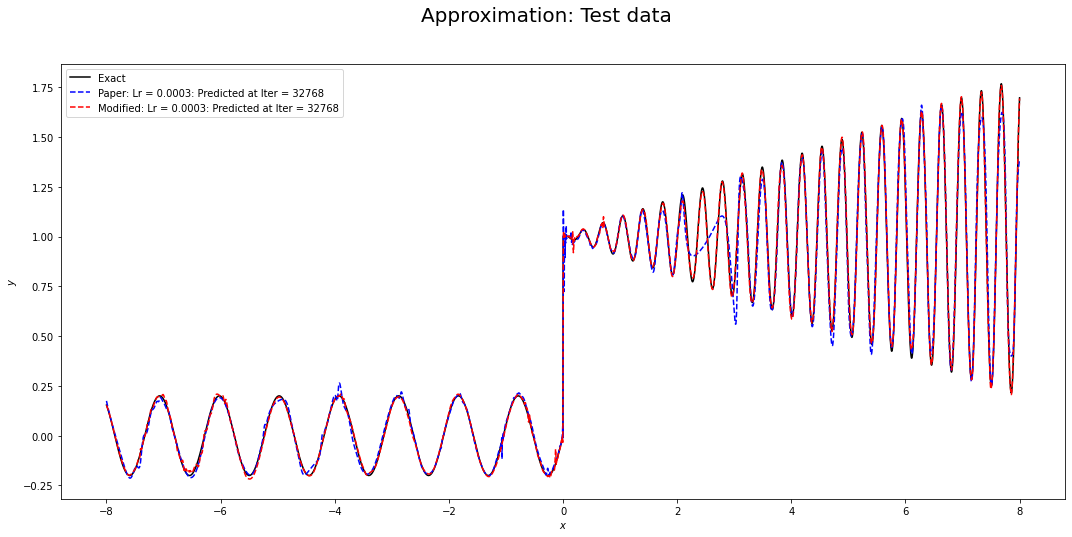

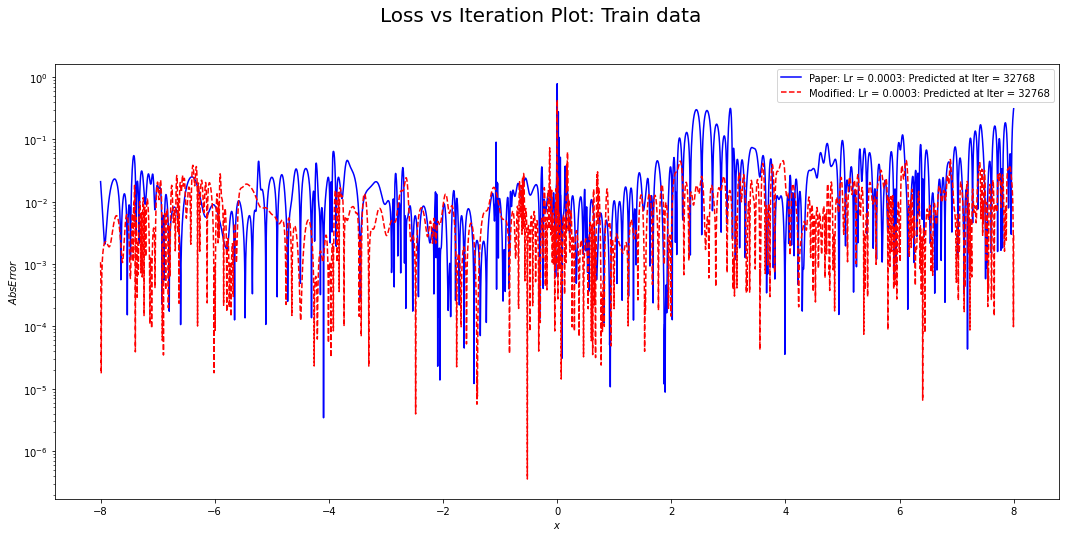

In [56]:
## Approximation ##
# print(len(x_test))""
Sol_paper = np.asarray(Solution_history[0]).reshape(-1, 1)
Sol_modified = np.asarray(Solution_history[1]).reshape(-1, 1)
fig = plt.figure(figsize=[18, 8])
plt.plot(test_x, test_y, 'k',  label = 'Exact')
plt.plot(test_x, Sol_paper , 'b--',  label = 'Paper: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
plt.plot(test_x, Sol_modified, 'r--',  label = 'Modified: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='best')
fig.suptitle('Approximation: Test data', fontsize=20)
## fig.savefig('/content/gdrive/My Drive/Colab Notebooks/stepFunction/Approx_adam_lr:0.0001_N=3000_Itr=60000_sawtooth_layers = [1] + 10*[1000] + [1].png')
 
 
# ## Abs Error ###
Sol_paper = Sol_paper.flatten()[:, None]
error_paper = np.abs(Sol_paper - test_y)

Sol_modified = Sol_modified.reshape(-1, 1).flatten()[:, None]
error_modified = np.abs(Sol_modified  - test_y)
 
fig = plt.figure(figsize=[18, 8])
plt.semilogy(test_x, error_paper, 'b-', label = 'Paper: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
plt.semilogy(test_x, error_modified, 'r--', label = 'Modified: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
plt.xlabel('$x$')
plt.ylabel('$Abs Error$')
plt.legend(loc='best')
fig.suptitle('Loss vs Iteration Plot: Train data', fontsize=20)
## fig.savefig('/content/gdrive/My Drive/Colab Notebooks/stepFunction/Abs_loss_adam_lr:0.0001_N=3000_Itr=60000_sawtooth_layers = [1] + 10*[1000] + [1].png')

# Sawtooth Wave

### Data Preparation 

train_x shape: (4096, 1)
train_y shape: (4096, 1)
test_x shape: (4096, 1)
test_y shape: (4096, 1)


Text(0.5, 0.98, 'Function: test')

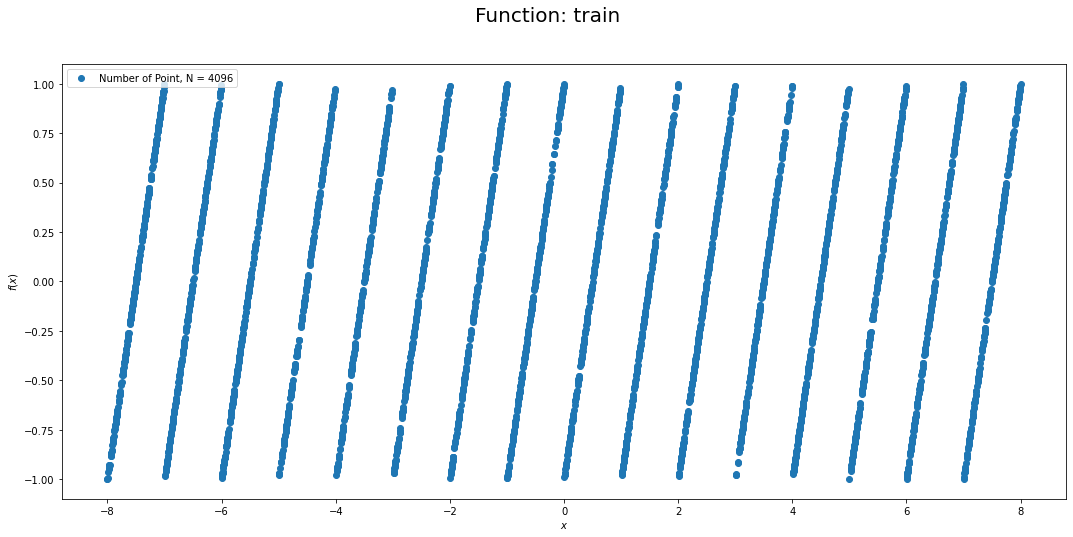

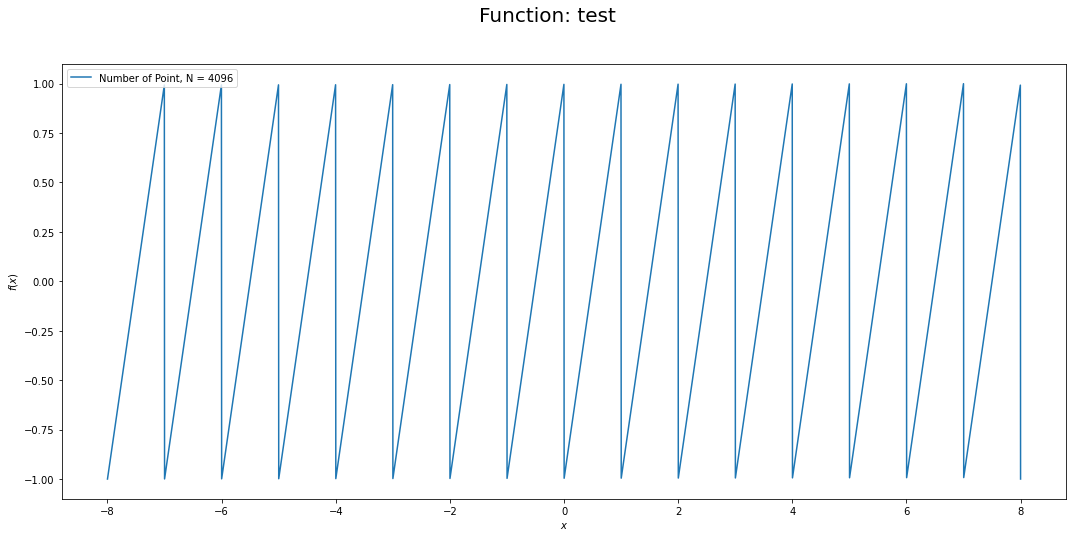

In [57]:
# ##====== Data Preparation ==========###
# N = 2**12 # number of trainig point
# print(f"Number of Data: {N}")
# print(f"Number of Training Data: {N}")
# # x = np.linspace(-3, 3, N + 1)

# lb = -1 # lower bound
# ub = 1 # uppder bound

# # ####### Synthetic Data Generation: Training ######### #
# x1 = chebNodes(lb, 0, N)
# x2 = chebNodes(0, ub, N)

frequency = 1

# x = np.concatenate((x1, x2), axis=None).reshape(-1, 1)
y = signal.sawtooth(2 * np.pi * frequency * x)

train_x = x
train_y = y

train_x = np.asarray(train_x, dtype=np.float32).reshape(-1, 1)
train_y = np.asarray(train_y, dtype=np.float32).reshape(-1, 1)

print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}")

fig = plt.figure(figsize=[18, 8])
plt.scatter(train_x, train_y, label = 'Number of Point, N = %d' %N)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='best')
fig.suptitle('Function: train', fontsize=20)

######## Synthetic Data Generation: Testing ##########
test_x = np.linspace(lb, ub, N, dtype=np.float32)
test_y = signal.sawtooth(2 * np.pi * frequency * test_x)

# plot_wave_and_spectrum(x, y)

test_x = np.asarray(test_x, dtype=np.float32).reshape(-1, 1)
test_y = np.asarray(test_y, dtype=np.float32).reshape(-1, 1)

print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_y.shape}")


fig = plt.figure(figsize=[18, 8])
plt.plot(test_x, test_y, label = 'Number of Point, N = %d' %N)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='best')
fig.suptitle('Function: test', fontsize=20)
# # fig.savefig('/content/drive/My Drive/Colab Notebooks/Current/sawtooth_wave.png')

### Network

Summary: 
Max Iteration: 32768
Number of training Data Points: 4096
Batch Size: 1024
Learning Rate: 0.0003
Layers:  1 50 50 50 50 1
For Learning rate =  0.0003
Steps : 8192, loss: 7.292e-02
Steps : 16384, loss: 1.469e-02
Steps : 24576, loss: 1.008e-02
Steps : 32768, loss: 1.281e-02
Training time: 00:02:05.22
================== Modified =====================
Summary: 
Max Iteration: 32768
Number of training Data Points: 4096
Batch Size: 1024
Learning Rate: 0.0003
Layers:  1 50 50 50 50 1
For Learning rate =  0.0003
Steps : 8192, loss: 6.559e-02
Steps : 16384, loss: 1.738e-02
Steps : 24576, loss: 1.903e-02
Steps : 32768, loss: 5.974e-03
Training time: 00:02:05.15


Text(0.5, 0.98, 'MSE vs Iteration Plot')

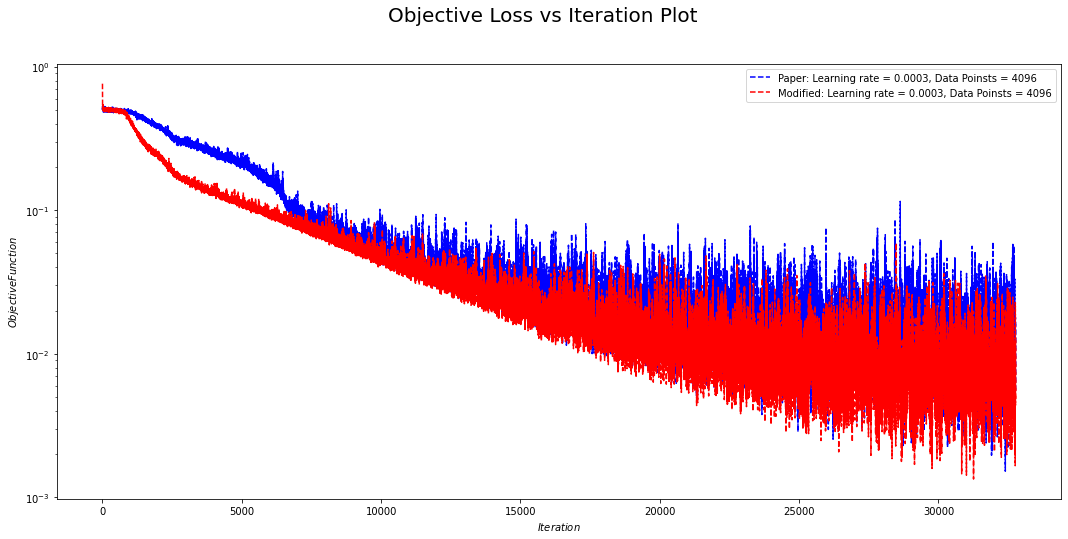

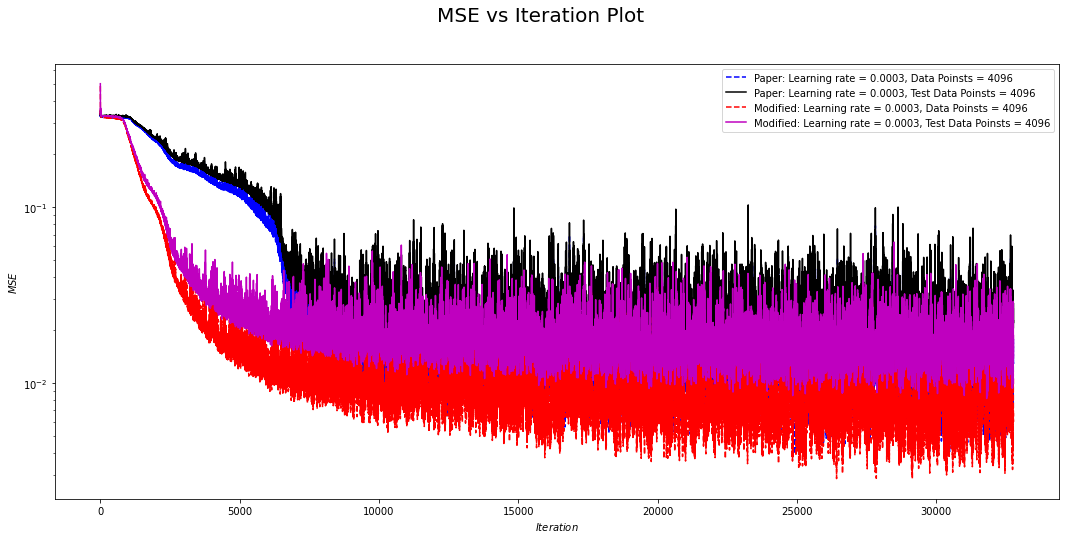

In [58]:
layers = [1] + 4*[50] + [1]   ## input = number_features, output = num_classes
# layers = [1, 1]
weights, biases, a = initialize_NN(layers)
nmax = 2**15 # Maximum Iteration

dropout = 0.2
keep = 1.0
nmax_25 = int(nmax * 0.25)
nmax_50 = int(nmax * 0.50)
nmax_75 = int(nmax * 0.75)
nmax_100 = int(nmax * 1)
 
 
N_batch = 2**10
 
# lr = 3.0e-4
# optimizer_adam = tf.train.AdamOptimizer(lr).minimize(obj_loss)
# optimizer_sgd = tf.train.GradientDescentOptimizer(lr).minimize(obj_loss)
 
############# Placeholder ###################
x_train = tf.placeholder(tf.float32, shape=[None, 1])
y_train = tf.placeholder(tf.float32, shape=[None, 1])
keep_prob = tf.placeholder(tf.float32)
# x_test = tf.placeholder(tf.float32, shape=[None, 1])
# y_test = tf.placeholder(tf.float32, shape=[None, 1])
 
###==================== Neural Network ==========================###
y_pred = neural_net(x_train, weights, biases, a, keep_prob)
# y_pred_modified = neural_net_modified(x_train, weights, biases, a)
 
obj_loss = tf.reduce_mean(tf.square(y_pred - y_train)) + S_exp(a) #+ S(a)
mse_loss = tf.reduce_mean(tf.square(y_pred - y_train)) # MSE 

MSE_history = []
MSE_history_real = []
Solution_history = []
Solution_history_test = []
MSE_history_real_test = []

lr = 3.0e-4
optimizer_adam = tf.train.AdamOptimizer(lr).minimize(obj_loss)
optimizer_sgd = tf.train.GradientDescentOptimizer(lr).minimize(obj_loss)
 
print("Summary: ")
print("Max Iteration: %d" %(nmax))
print("Number of training Data Points: %d" %N)
print("Batch Size: %d" %N_batch)
print("Learning Rate: %0.4f" %(lr))
print("Layers: ", *layers)

 
# Add ops to save and restore all the variables.
# saver = tf.train.Saver()
sess = tf.Session()
 
init = tf.global_variables_initializer()   
 
sess.run(init)
n = 0
 
MSE_hist = []
Sol = []
mse_hist = []
mse_hist_test = []
# Sol_test = []
# Sol_modified = []
# a_hist = []
# print(datetime.datetime.now())
print("For Learning rate = ", lr)
 
start_time = time.time()
 
while n <= nmax:
    n = n + 1
 
    x_batch, y_batch = fetch_minibatch(train_x, train_y, N_batch)
    obj_loss_, _, y_ = sess.run([obj_loss, optimizer_adam, y_pred], feed_dict={x_train: x_batch, y_train: y_batch, keep_prob: dropout})

    mse = sess.run([mse_loss], feed_dict={x_train: train_x, y_train: train_y, keep_prob: keep})
    mse_hist.append(mse)
    MSE_hist.append(obj_loss_)  

    mse_test, _ = sess.run([mse_loss, y_pred], feed_dict={x_train: test_x, y_train: test_y, keep_prob: keep})
    mse_hist_test.append(mse_test)
 
    if n == nmax_25 or n == nmax_50 or n == nmax_75 or n == nmax_100:
        print('Steps : %d, loss: %0.3e'%(n, obj_loss_))
    if n == nmax_100:
        y_ = sess.run([y_pred], feed_dict={x_train: test_x, y_train: test_y, keep_prob: keep})
        Sol.append(y_)

 
 
MSE_history.append(MSE_hist)
Solution_history.append(Sol)
MSE_history_real.append(mse_hist)
MSE_history_real_test.append(mse_hist_test)
# Solution_history_test.append(Sol_test)
 
sess.close()
tf.reset_default_graph()
 
elapsed = time.time() - start_time                  
hours, rem = divmod(elapsed, 3600)                
minutes, seconds = divmod(rem, 60)                 
print('Training time: {:0>2}:{:0>2}:{:05.2f}'.format(int(hours), int(minutes), seconds))
 
 
print("================== Modified =====================")
 
weights, biases, a = initialize_NN(layers)
 
############# Placeholder ###################
x_train = tf.placeholder(tf.float32, shape=[None, 1])
y_train = tf.placeholder(tf.float32, shape=[None, 1])
keep_prob = tf.placeholder(tf.float32)
 
# x_test = tf.placeholder(tf.float32, shape=[None, 1])
# y_test = tf.placeholder(tf.float32, shape=[None, 1])
###============= Neural Network ========###
# y_pred = neural_net(x_train, weights, biases, a)
y_pred = neural_net_modified(x_train, weights, biases, a, keep_prob)
 
obj_loss = tf.reduce_mean(tf.square(y_pred - y_train)) + S_exp(a) #+ S(a)
mse_loss = tf.reduce_mean(tf.square(y_pred - y_train)) # MSE 
 
lr = 3.0e-4

optimizer_adam = tf.train.AdamOptimizer(lr).minimize(obj_loss)
optimizer_sgd = tf.train.GradientDescentOptimizer(lr).minimize(obj_loss)
 
# Add ops to save and restore all the variables.
# saver = tf.train.Saver()
 
print("Summary: ")
print("Max Iteration: %d" %(nmax))
print("Number of training Data Points: %d" %N)
print("Batch Size: %d" %N_batch)
print("Learning Rate: %0.4f" %(lr))
print("Layers: ", *layers)
 
sess = tf.Session()
 
init = tf.global_variables_initializer()   
 
sess.run(init)
 
n = 0
 
# MSE_hist = []
# mse_hist = []
# Sol = []

MSE_hist = []
Sol = []
mse_hist = []
mse_hist_test = []

# Sol_test = []
# print(datetime.datetime.now())
print("For Learning rate = ", lr)
 
 
start_time = time.time()

while n <= nmax:
    n = n + 1
    x_batch, y_batch = fetch_minibatch(train_x, train_y, N_batch)
    obj_loss_, _, y_ = sess.run([obj_loss, optimizer_adam, y_pred], feed_dict={x_train: x_batch, y_train: y_batch, keep_prob: dropout})
    mse = sess.run([mse_loss], feed_dict={x_train: train_x, y_train: train_y, keep_prob: keep})
    mse_hist.append(mse)
    MSE_hist.append(obj_loss_)

    mse_test, _ = sess.run([mse_loss, y_pred], feed_dict={x_train: test_x, y_train: test_y, keep_prob: keep})
    mse_hist_test.append(mse_test)    
 
    if n == nmax_25 or n == nmax_50 or n == nmax_75 or n == nmax_100:
        print('Steps : %d, loss: %0.3e'%(n, obj_loss_))
    if n == nmax_100:
        y_ = sess.run([y_pred], feed_dict={x_train: test_x, y_train: test_y, keep_prob: keep})
        Sol.append(y_)

 
##==================!Start Time!====================##
elapsed = time.time() - start_time                  
hours, rem = divmod(elapsed, 3600)                
minutes, seconds = divmod(rem, 60)                 
print('Training time: {:0>2}:{:0>2}:{:05.2f}'.format(int(hours), int(minutes), seconds))
 
################# Append ###############
# MSE_history.append(MSE_hist)
# Solution_history_paper.append(Sol_paper)
# Solution_history_modified.append(Sol_modified)
MSE_history.append(MSE_hist)
Solution_history.append(Sol)
MSE_history_real.append(mse_hist)
MSE_history_real_test.append(mse_hist_test)
# Solution_history_test.append(Sol_test)

 
# MSE_history.append(MSE_hist)
# # trainLoss_history.append(train_loss_hist)
# # testLoss_history.append(test_loss_hist)
# Solution_history.append(Sol)
##==================!End Time!======================##
 
##================ Save the Model ================##
# /content/gdrive/My Drive/Colab Notebooks/Experiment
# save_path = saver.save(sess, "/content/gdrive/My Drive/Colab Notebooks/Experiment/Model/reproduction.ckpt")
# print("Model saved in path: %s" % save_path)
# tf.reset_default_graph()
 
### Risk function ####
fig = plt.figure(figsize=[18, 8])
plt.semilogy(MSE_history[0], 'b--', label = 'Paper: Learning rate = %0.4f, Data Poinsts = %d' %(lr, N))
plt.semilogy(MSE_history[1], 'r--', label = 'Modified: Learning rate = %0.4f, Data Poinsts = %d' %(lr, N))
plt.xlabel('$Iteration$')
plt.ylabel('$Objective Function$')
plt.legend(loc='best')
fig.suptitle('Objective Loss vs Iteration Plot', fontsize=20)
# fig.savefig('/content/gdrive/My Drive/Colab Notebooks/stepFunction/MSE_Loss_adam_lr:0.0001_N=3000_Itr=60000_sawtooth_layers = [1] + 10*[1000] + [1].png')

############# MSE loss function ##############
fig = plt.figure(figsize=[18, 8])
plt.semilogy(MSE_history_real[0], 'b--', label = 'Paper: Learning rate = %0.4f, Data Poinsts = %d' %(lr, N))
plt.semilogy(MSE_history_real_test[0], 'k', label = 'Paper: Learning rate = %0.4f, Test Data Poinsts = %d' %(lr, N))
plt.semilogy(MSE_history_real[1], 'r--', label = 'Modified: Learning rate = %0.4f, Data Poinsts = %d' %(lr, N))
plt.semilogy(MSE_history_real_test[1], 'm', label = 'Modified: Learning rate = %0.4f, Test Data Poinsts = %d' %(lr, N))
plt.xlabel('$Iteration$')
plt.ylabel('$MSE$')
plt.legend(loc='best')
fig.suptitle('MSE vs Iteration Plot', fontsize=20)

### Testing

Text(0.5, 0.98, 'Loss vs Iteration Plot: Train data')

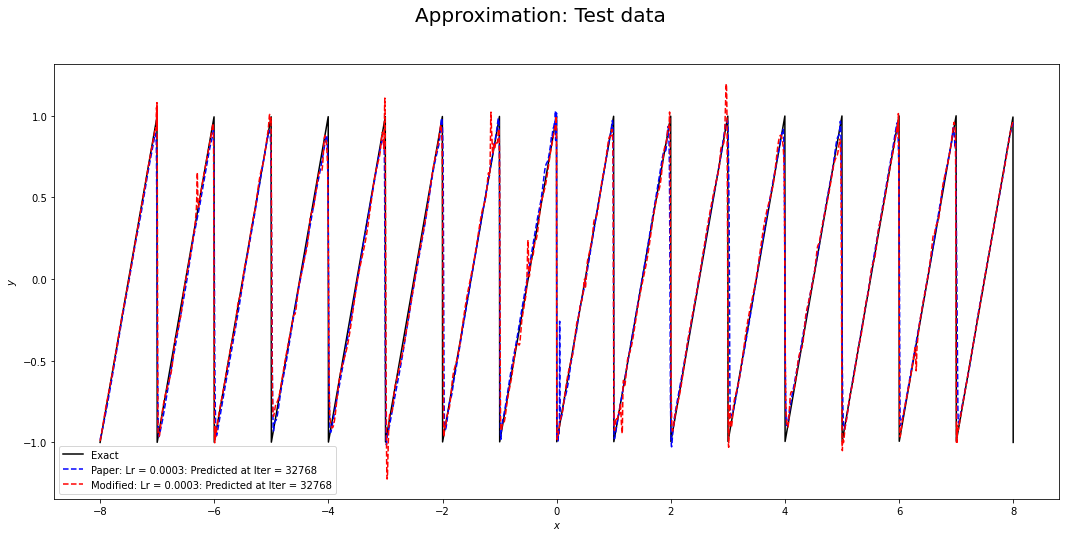

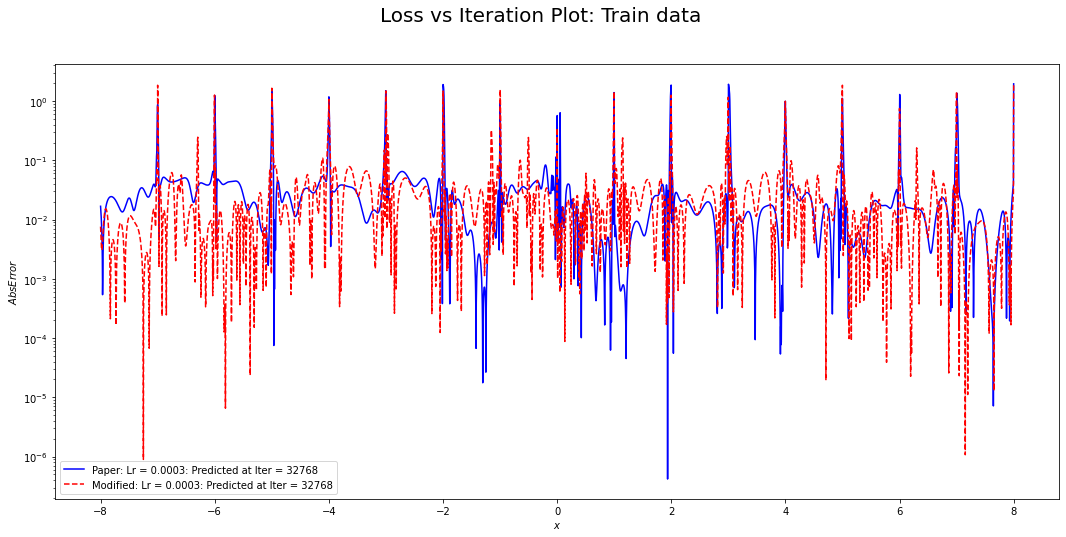

In [59]:
## Approximation ##
# print(len(x_test))""
Sol_paper = np.asarray(Solution_history[0]).reshape(-1, 1)
Sol_modified = np.asarray(Solution_history[1]).reshape(-1, 1)
fig = plt.figure(figsize=[18, 8])
plt.plot(test_x, test_y, 'k',  label = 'Exact')
plt.plot(test_x, Sol_paper , 'b--',  label = 'Paper: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
plt.plot(test_x, Sol_modified, 'r--',  label = 'Modified: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='best')
fig.suptitle('Approximation: Test data', fontsize=20)
## fig.savefig('/content/gdrive/My Drive/Colab Notebooks/stepFunction/Approx_adam_lr:0.0001_N=3000_Itr=60000_sawtooth_layers = [1] + 10*[1000] + [1].png')
 
 
# ## Abs Error ###
Sol_paper = Sol_paper.flatten()[:, None]
error_paper = np.abs(Sol_paper - test_y)

Sol_modified = Sol_modified.reshape(-1, 1).flatten()[:, None]
error_modified = np.abs(Sol_modified  - test_y)
 
fig = plt.figure(figsize=[18, 8])
plt.semilogy(test_x, error_paper, 'b-', label = 'Paper: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
plt.semilogy(test_x, error_modified, 'r--', label = 'Modified: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
plt.xlabel('$x$')
plt.ylabel('$Abs Error$')
plt.legend(loc='best')
fig.suptitle('Loss vs Iteration Plot: Train data', fontsize=20)
## fig.savefig('/content/gdrive/My Drive/Colab Notebooks/stepFunction/Abs_loss_adam_lr:0.0001_N=3000_Itr=60000_sawtooth_layers = [1] + 10*[1000] + [1].png')
 
################## Test Data #####################
 
# Sol_test_paper = np.asarray(Solution_history_test[0]).reshape(-1, 1)
# Sol_test_modified = np.asarray(Solution_history_test[1]).reshape(-1, 1)


# plot_wave_and_spectrum(x, Sol_test_modified)



# fig = plt.figure(figsize=[18, 8])
# plt.plot(x, y, 'k',  label = 'Exact')
# plt.plot(x, Sol_test_paper, 'b--',  label = 'Paper: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
# plt.plot(x, Sol_test_modified, 'r--',  label = 'Modified: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
# plt.xlabel('$x$')
# plt.ylabel('$y$')
# plt.legend(loc='best')
# fig.suptitle('Approximation: test data', fontsize=20)
 
 
 
 
# ## Abs Error ###
# Sol_test_paper = Sol_test_paper.flatten()[:, None]
# error_test_paper = np.abs(Sol_test_paper - y)
 
# Sol_test_modified = Sol_test_modified.reshape(-1, 1).flatten()[:, None]
# error_test_modified = np.abs(Sol_test_modified - y)
 
# fig = plt.figure(figsize=[18, 8])
# plt.semilogy(x, error_test_paper, 'b-', label = 'Paper: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
# plt.semilogy(x, error_test_modified, 'r--', label = 'Modified: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
# plt.xlabel('$x$')
# plt.ylabel('$Abs Error$')
# plt.legend(loc='best')
# fig.suptitle('Loss vs Iteration Plot: test data', fontsize=20)
# # fig.savefig('/content/gdrive/My Drive/Colab Notebooks/stepFunction/Abs_loss_adam_lr:0.0001_N=3000_Itr=60000_sawtooth_layers = [1] + 10*[1000] + [1].png')

# Smooth Function

### Data Preparation

train_x shape: (4096, 1)
train_y shape: (4096, 1)
test_x shape: (4096, 1)
test_y shape: (4096, 1)


Text(0.5, 0.98, 'Function: test')

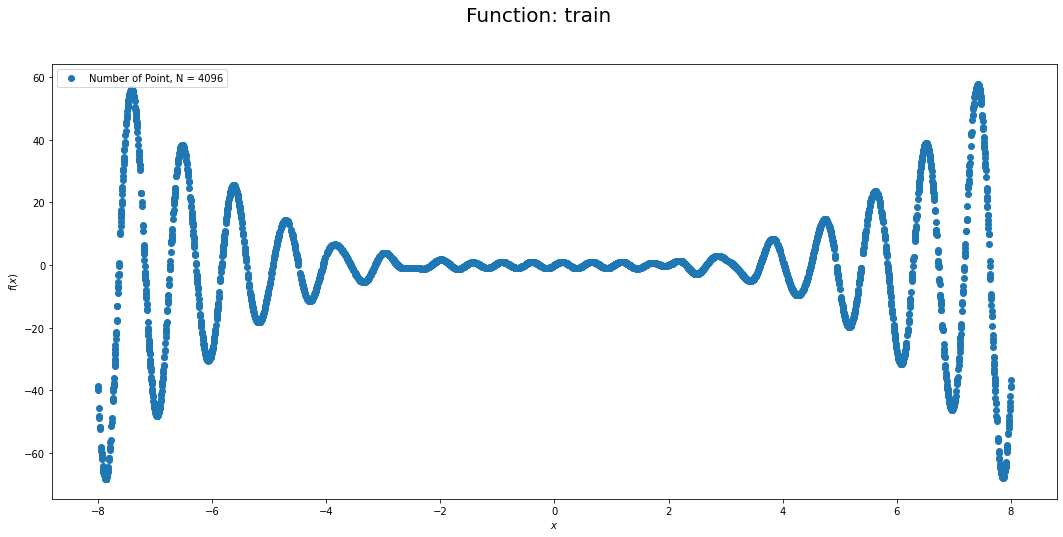

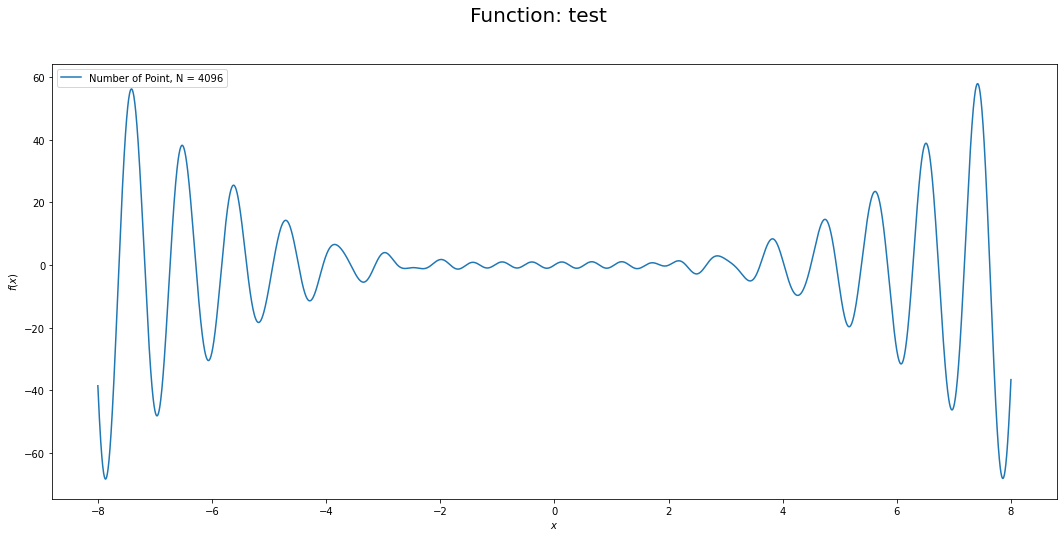

In [60]:
# ##====== Data Preparation ==========###
# N = 2**12 # number of trainig point
# print(f"Number of Data: {N}")
# print(f"Number of Training Data: {N}")
# # x = np.linspace(-3, 3, N + 1)

# lb = -8 # lower bound
# ub = 8 # uppder bound

# # ####### Synthetic Data Generation: Training ######### #
# x1 = chebNodes(lb, 0, N)
# x2 = chebNodes(0, ub, N)
# x = np.concatenate((x1, x2), axis=None).reshape(-1, 1)

# # x_dim = 1
# # y_dim = 1

# # lb = lb*np.ones((1, x_dim))
# # ub = ub*np.ones((1, x_dim))

# # # x = lb + (ub - lb)*lhs(x_dim, N)
# # x = chebNodes(lb, ub, N)


y = smooth_function(x)

train_x = x
train_y = y

train_x = np.asarray(train_x, dtype=np.float32).reshape(-1, 1)
train_y = np.asarray(train_y, dtype=np.float32).reshape(-1, 1)

print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}")

fig = plt.figure(figsize=[18, 8])
plt.scatter(train_x, train_y, label = 'Number of Point, N = %d' %N)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='best')
fig.suptitle('Function: train', fontsize=20)

######## Synthetic Data Generation: Testing ##########
test_x = np.linspace(lb, ub, N, dtype=np.float32)
test_y = smooth_function(test_x)

# plot_wave_and_spectrum(x, y)

test_x = np.asarray(test_x, dtype=np.float32).reshape(-1, 1)
test_y = np.asarray(test_y, dtype=np.float32).reshape(-1, 1)

print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_y.shape}")
fig = plt.figure(figsize=[18, 8])
plt.plot(test_x, test_y, label = 'Number of Point, N = %d' %N)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='best')
fig.suptitle('Function: test', fontsize=20)
# # fig.savefig('/content/drive/My Drive/Colab Notebooks/Current/sawtooth_wave.png')

# ############ Trainig Data ################
# # x1 = chebNodes(a, 0, N)
# # x2 = chebNodes(0, b, N)
# # x = np.concatenate((x1, x2), axis=None).reshape(-1, 1)


# # idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
# # print(x.shape)

# train_N = 2**11


# indx = np.random.choice(x.shape[0], train_N, replace=False)

# train_x = x[indx, :]
# train_y = y[indx, :]

# # print(f"x_train shape: {train_x.shape}")
# # print(f"y_train shape: {train_y.shape}")

# # plot_wave_and_spectrum(x_train, y_train)

# fig = plt.figure(figsize=[18, 8])
# plt.scatter(train_x, train_y, label = 'Number of training Points, Train_N = %d' %train_N)
# plt.xlabel('$x$')
# plt.ylabel('$f(x)$')
# plt.legend(loc='best')
# fig.suptitle('Train Data', fontsize=20)


# # y = np.sin(2*np.pi*1*x)

# print(f"Number of points: {N}")
# print(f"Number of training points: {train_N}")



################### Testing/Validation Data ###################

# n = 2**9 # Testing points
# x1 = chebNodes(a, 0, n)
# x2 = chebNodes(0, b, n)
# x_test = np.concatenate((x1, x2), axis=None).reshape(-1, 1)
# # x_test = np.linspace(a, b, N, dtype=np.float32).reshape(-1, 1)
# y_test = non_linear_step_function(x_test)

# x_test = np.asarray(x_test, dtype=np.float32)
# y_test = np.asarray(y_test, dtype=np.float32)


# print(f"x train shape: {x.shape}")
# print(f"x_test shape: {x_test.shape}")

# print(f"y_train shape: {y.shape}")
# print(f"y_test shape: {y_test.shape}")

# ## Comparing Trainig and testing data
# # print("Train and test data same?: " , np.allclose(x, x_test))



# # print(type(y_test))
# fig = plt.figure(figsize=[18, 8])
# # plt.plot(x,y)
# # plt.plot(x_test, y_test, label = 'Number of Point, N = %d' %N)
# plt.scatter(x_test, y_test)
# plt.xlabel('$x$')
# plt.ylabel('$f(x)$')
# plt.legend(loc='best')
# fig.suptitle('Function', fontsize=20)
# # # fig.savefig('/content/drive/My Drive/Colab Notebooks/Current/sawtooth_wave.png')


### Network

Summary: 
Max Iteration: 32768
Number of training Data Points: 4096
Batch Size: 1024
Learning Rate: 0.0003
Layers:  1 50 50 50 50 1
For Learning rate =  0.0003
Steps : 8192, loss: 2.883e+02
Steps : 16384, loss: 1.791e+02
Steps : 24576, loss: 1.818e+02
Steps : 32768, loss: 1.449e+02
Training time: 00:02:06.31
================== Modified =====================
Summary: 
Max Iteration: 32768
Number of training Data Points: 4096
Batch Size: 1024
Learning Rate: 0.0003
Layers:  1 50 50 50 50 1
For Learning rate =  0.0003
Steps : 8192, loss: 1.074e+02
Steps : 16384, loss: 6.579e+01
Steps : 24576, loss: 5.560e+00
Steps : 32768, loss: 1.009e+00
Training time: 00:02:05.08


Text(0.5, 0.98, 'MSE vs Iteration Plot')

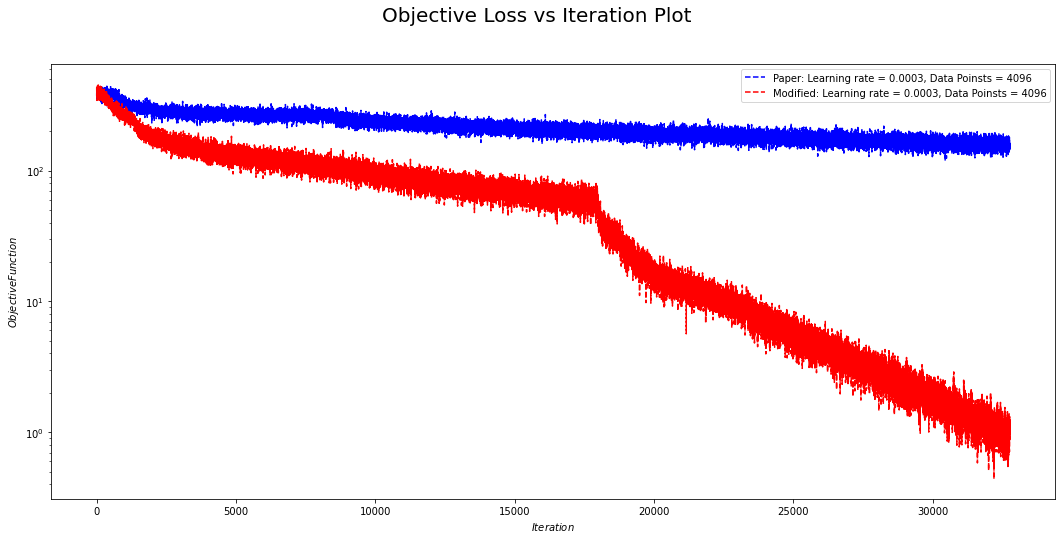

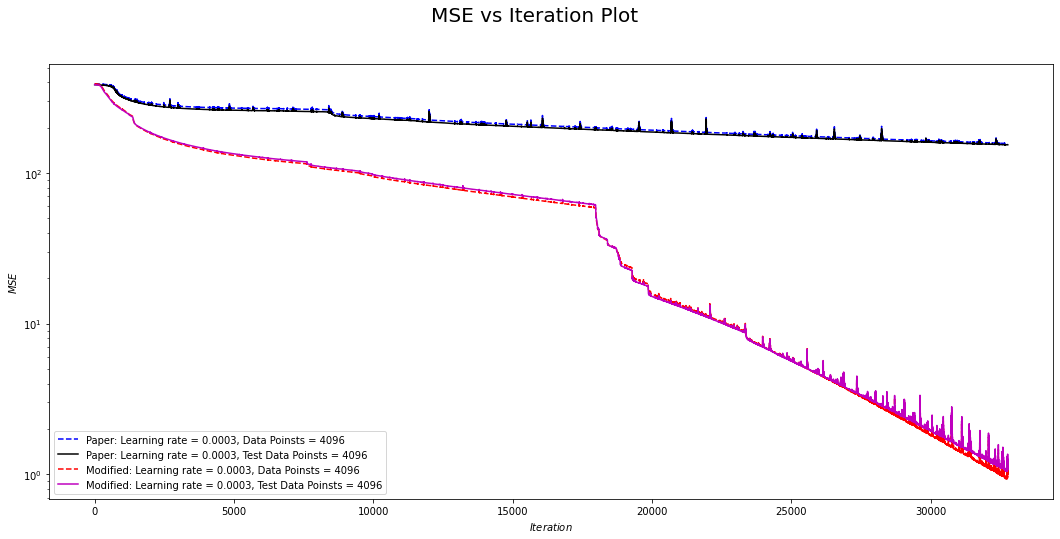

In [61]:
layers = [1] + 4*[50] + [1]   ## input = number_features, output = num_classes
# layers = [1, 1]
weights, biases, a = initialize_NN(layers)
nmax = 2**15 # Maximum Iteration

dropout = 0.2
keep = 1.0
nmax_25 = int(nmax * 0.25)
nmax_50 = int(nmax * 0.50)
nmax_75 = int(nmax * 0.75)
nmax_100 = int(nmax * 1)
 
 
N_batch = 2**10
 
# lr = 3.0e-4
# optimizer_adam = tf.train.AdamOptimizer(lr).minimize(obj_loss)
# optimizer_sgd = tf.train.GradientDescentOptimizer(lr).minimize(obj_loss)
 
############# Placeholder ###################
x_train = tf.placeholder(tf.float32, shape=[None, 1])
y_train = tf.placeholder(tf.float32, shape=[None, 1])
keep_prob = tf.placeholder(tf.float32)
# x_test = tf.placeholder(tf.float32, shape=[None, 1])
# y_test = tf.placeholder(tf.float32, shape=[None, 1])
 
###==================== Neural Network ==========================###
y_pred = neural_net(x_train, weights, biases, a, keep_prob)
# y_pred_modified = neural_net_modified(x_train, weights, biases, a)
 
obj_loss = tf.reduce_mean(tf.square(y_pred - y_train)) + S_exp(a) #+ S(a)
mse_loss = tf.reduce_mean(tf.square(y_pred - y_train)) # MSE 

MSE_history = []
MSE_history_real = []
Solution_history = []
Solution_history_test = []
MSE_history_real_test = []

lr = 3.0e-4
optimizer_adam = tf.train.AdamOptimizer(lr).minimize(obj_loss)
optimizer_sgd = tf.train.GradientDescentOptimizer(lr).minimize(obj_loss)
 
print("Summary: ")
print("Max Iteration: %d" %(nmax))
print("Number of training Data Points: %d" %N)
print("Batch Size: %d" %N_batch)
print("Learning Rate: %0.4f" %(lr))
print("Layers: ", *layers)

 
# Add ops to save and restore all the variables.
# saver = tf.train.Saver()
sess = tf.Session()
 
init = tf.global_variables_initializer()   
 
sess.run(init)
n = 0
 
MSE_hist = []
Sol = []
mse_hist = []
mse_hist_test = []
# Sol_test = []
# Sol_modified = []
# a_hist = []
# print(datetime.datetime.now())
print("For Learning rate = ", lr)
 
start_time = time.time()
 
while n <= nmax:
    n = n + 1
 
    x_batch, y_batch = fetch_minibatch(train_x, train_y, N_batch)
    obj_loss_, _, y_ = sess.run([obj_loss, optimizer_adam, y_pred], feed_dict={x_train: x_batch, y_train: y_batch, keep_prob: dropout})

    mse = sess.run([mse_loss], feed_dict={x_train: train_x, y_train: train_y, keep_prob: keep})
    mse_hist.append(mse)
    MSE_hist.append(obj_loss_)  

    mse_test, _ = sess.run([mse_loss, y_pred], feed_dict={x_train: test_x, y_train: test_y, keep_prob: keep})
    mse_hist_test.append(mse_test)
 
    if n == nmax_25 or n == nmax_50 or n == nmax_75 or n == nmax_100:
        print('Steps : %d, loss: %0.3e'%(n, obj_loss_))
    if n == nmax_100:
        y_ = sess.run([y_pred], feed_dict={x_train: test_x, y_train: test_y, keep_prob: keep})
        Sol.append(y_)

 
 
MSE_history.append(MSE_hist)
Solution_history.append(Sol)
MSE_history_real.append(mse_hist)
MSE_history_real_test.append(mse_hist_test)
# Solution_history_test.append(Sol_test)
 
sess.close()
tf.reset_default_graph()
 
elapsed = time.time() - start_time                  
hours, rem = divmod(elapsed, 3600)                
minutes, seconds = divmod(rem, 60)                 
print('Training time: {:0>2}:{:0>2}:{:05.2f}'.format(int(hours), int(minutes), seconds))
 
 
print("================== Modified =====================")
 
weights, biases, a = initialize_NN(layers)
 
############# Placeholder ###################
x_train = tf.placeholder(tf.float32, shape=[None, 1])
y_train = tf.placeholder(tf.float32, shape=[None, 1])
keep_prob = tf.placeholder(tf.float32)
 
# x_test = tf.placeholder(tf.float32, shape=[None, 1])
# y_test = tf.placeholder(tf.float32, shape=[None, 1])
###============= Neural Network ========###
# y_pred = neural_net(x_train, weights, biases, a)
y_pred = neural_net_modified(x_train, weights, biases, a, keep_prob)
 
obj_loss = tf.reduce_mean(tf.square(y_pred - y_train)) + S_exp(a) #+ S(a)
mse_loss = tf.reduce_mean(tf.square(y_pred - y_train)) # MSE 
 
lr = 3.0e-4

optimizer_adam = tf.train.AdamOptimizer(lr).minimize(obj_loss)
optimizer_sgd = tf.train.GradientDescentOptimizer(lr).minimize(obj_loss)
 
# Add ops to save and restore all the variables.
# saver = tf.train.Saver()
 
print("Summary: ")
print("Max Iteration: %d" %(nmax))
print("Number of training Data Points: %d" %N)
print("Batch Size: %d" %N_batch)
print("Learning Rate: %0.4f" %(lr))
print("Layers: ", *layers)
 
sess = tf.Session()
 
init = tf.global_variables_initializer()   
 
sess.run(init)
 
n = 0
 
# MSE_hist = []
# mse_hist = []
# Sol = []

MSE_hist = []
Sol = []
mse_hist = []
mse_hist_test = []

# Sol_test = []
# print(datetime.datetime.now())
print("For Learning rate = ", lr)
 
 
start_time = time.time()

while n <= nmax:
    n = n + 1
    x_batch, y_batch = fetch_minibatch(train_x, train_y, N_batch)
    obj_loss_, _, y_ = sess.run([obj_loss, optimizer_adam, y_pred], feed_dict={x_train: x_batch, y_train: y_batch, keep_prob: dropout})
    mse = sess.run([mse_loss], feed_dict={x_train: train_x, y_train: train_y, keep_prob: keep})
    mse_hist.append(mse)
    MSE_hist.append(obj_loss_)

    mse_test, _ = sess.run([mse_loss, y_pred], feed_dict={x_train: test_x, y_train: test_y, keep_prob: keep})
    mse_hist_test.append(mse_test)    
 
    if n == nmax_25 or n == nmax_50 or n == nmax_75 or n == nmax_100:
        print('Steps : %d, loss: %0.3e'%(n, obj_loss_))
    if n == nmax_100:
        y_ = sess.run([y_pred], feed_dict={x_train: test_x, y_train: test_y, keep_prob: keep})
        Sol.append(y_)

 
##==================!Start Time!====================##
elapsed = time.time() - start_time                  
hours, rem = divmod(elapsed, 3600)                
minutes, seconds = divmod(rem, 60)                 
print('Training time: {:0>2}:{:0>2}:{:05.2f}'.format(int(hours), int(minutes), seconds))
 
################# Append ###############
# MSE_history.append(MSE_hist)
# Solution_history_paper.append(Sol_paper)
# Solution_history_modified.append(Sol_modified)
MSE_history.append(MSE_hist)
Solution_history.append(Sol)
MSE_history_real.append(mse_hist)
MSE_history_real_test.append(mse_hist_test)
# Solution_history_test.append(Sol_test)

 
# MSE_history.append(MSE_hist)
# # trainLoss_history.append(train_loss_hist)
# # testLoss_history.append(test_loss_hist)
# Solution_history.append(Sol)
##==================!End Time!======================##
 
##================ Save the Model ================##
# /content/gdrive/My Drive/Colab Notebooks/Experiment
# save_path = saver.save(sess, "/content/gdrive/My Drive/Colab Notebooks/Experiment/Model/reproduction.ckpt")
# print("Model saved in path: %s" % save_path)
# tf.reset_default_graph()
 
### Risk function ####
fig = plt.figure(figsize=[18, 8])
plt.semilogy(MSE_history[0], 'b--', label = 'Paper: Learning rate = %0.4f, Data Poinsts = %d' %(lr, N))
plt.semilogy(MSE_history[1], 'r--', label = 'Modified: Learning rate = %0.4f, Data Poinsts = %d' %(lr, N))
plt.xlabel('$Iteration$')
plt.ylabel('$Objective Function$')
plt.legend(loc='best')
fig.suptitle('Objective Loss vs Iteration Plot', fontsize=20)
# fig.savefig('/content/gdrive/My Drive/Colab Notebooks/stepFunction/MSE_Loss_adam_lr:0.0001_N=3000_Itr=60000_sawtooth_layers = [1] + 10*[1000] + [1].png')

############# MSE loss function ##############
fig = plt.figure(figsize=[18, 8])
plt.semilogy(MSE_history_real[0], 'b--', label = 'Paper: Learning rate = %0.4f, Data Poinsts = %d' %(lr, N))
plt.semilogy(MSE_history_real_test[0], 'k', label = 'Paper: Learning rate = %0.4f, Test Data Poinsts = %d' %(lr, N))
plt.semilogy(MSE_history_real[1], 'r--', label = 'Modified: Learning rate = %0.4f, Data Poinsts = %d' %(lr, N))
plt.semilogy(MSE_history_real_test[1], 'm', label = 'Modified: Learning rate = %0.4f, Test Data Poinsts = %d' %(lr, N))
plt.xlabel('$Iteration$')
plt.ylabel('$MSE$')
plt.legend(loc='best')
fig.suptitle('MSE vs Iteration Plot', fontsize=20)

### Testing

Text(0.5, 0.98, 'Loss vs Iteration Plot: Train data')

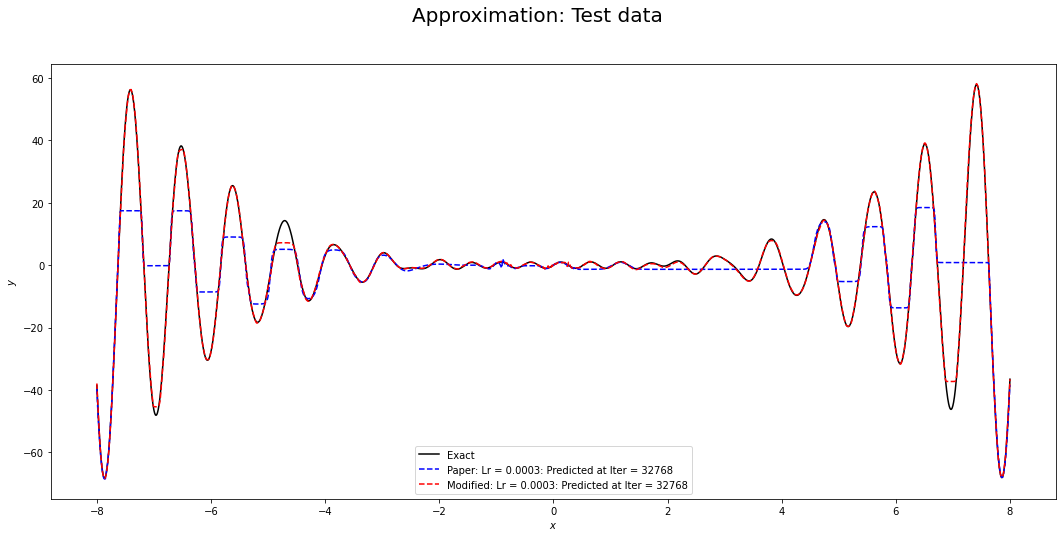

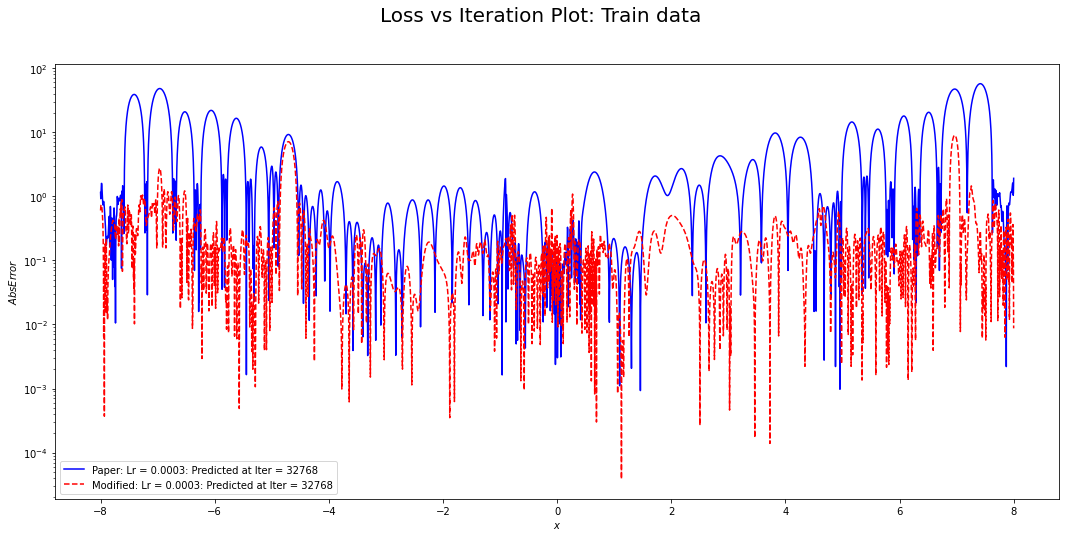

In [62]:
## Approximation ##
# print(len(x_test))""
Sol_paper = np.asarray(Solution_history[0]).reshape(-1, 1)
Sol_modified = np.asarray(Solution_history[1]).reshape(-1, 1)
fig = plt.figure(figsize=[18, 8])
plt.plot(test_x, test_y, 'k',  label = 'Exact')
plt.plot(test_x, Sol_paper , 'b--',  label = 'Paper: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
plt.plot(test_x, Sol_modified, 'r--',  label = 'Modified: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='best')
fig.suptitle('Approximation: Test data', fontsize=20)
## fig.savefig('/content/gdrive/My Drive/Colab Notebooks/stepFunction/Approx_adam_lr:0.0001_N=3000_Itr=60000_sawtooth_layers = [1] + 10*[1000] + [1].png')
 
 
# ## Abs Error ###
Sol_paper = Sol_paper.flatten()[:, None]
error_paper = np.abs(Sol_paper - test_y)

Sol_modified = Sol_modified.reshape(-1, 1).flatten()[:, None]
error_modified = np.abs(Sol_modified  - test_y)
 
fig = plt.figure(figsize=[18, 8])
plt.semilogy(test_x, error_paper, 'b-', label = 'Paper: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
plt.semilogy(test_x, error_modified, 'r--', label = 'Modified: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
plt.xlabel('$x$')
plt.ylabel('$Abs Error$')
plt.legend(loc='best')
fig.suptitle('Loss vs Iteration Plot: Train data', fontsize=20)
## fig.savefig('/content/gdrive/My Drive/Colab Notebooks/stepFunction/Abs_loss_adam_lr:0.0001_N=3000_Itr=60000_sawtooth_layers = [1] + 10*[1000] + [1].png')
 
################## Test Data #####################
 
# Sol_test_paper = np.asarray(Solution_history_test[0]).reshape(-1, 1)
# Sol_test_modified = np.asarray(Solution_history_test[1]).reshape(-1, 1)


# plot_wave_and_spectrum(x, Sol_test_modified)



# fig = plt.figure(figsize=[18, 8])
# plt.plot(x, y, 'k',  label = 'Exact')
# plt.plot(x, Sol_test_paper, 'b--',  label = 'Paper: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
# plt.plot(x, Sol_test_modified, 'r--',  label = 'Modified: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
# plt.xlabel('$x$')
# plt.ylabel('$y$')
# plt.legend(loc='best')
# fig.suptitle('Approximation: test data', fontsize=20)
 
 
 
 
# ## Abs Error ###
# Sol_test_paper = Sol_test_paper.flatten()[:, None]
# error_test_paper = np.abs(Sol_test_paper - y)
 
# Sol_test_modified = Sol_test_modified.reshape(-1, 1).flatten()[:, None]
# error_test_modified = np.abs(Sol_test_modified - y)
 
# fig = plt.figure(figsize=[18, 8])
# plt.semilogy(x, error_test_paper, 'b-', label = 'Paper: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
# plt.semilogy(x, error_test_modified, 'r--', label = 'Modified: Lr = %0.4f: Predicted at Iter = %d' %(lr, nmax))
# plt.xlabel('$x$')
# plt.ylabel('$Abs Error$')
# plt.legend(loc='best')
# fig.suptitle('Loss vs Iteration Plot: test data', fontsize=20)
# # fig.savefig('/content/gdrive/My Drive/Colab Notebooks/stepFunction/Abs_loss_adam_lr:0.0001_N=3000_Itr=60000_sawtooth_layers = [1] + 10*[1000] + [1].png')

In [63]:
# Play an audio beep. Any audio URL will do.
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')